In [18]:
import sys
sys.path.insert(1, '../src')

import numpy as np
import matplotlib.pyplot as plt 
import torch
import h5py

from GBRBM import GBRBM

device = torch.device("cuda")
dtype = torch.float

In [ ]:
data = torch.tensor(torch.load('../dataset/yeast.pt'), device = device, dtype = dtype)

# TRAINING

In [ ]:
Nv = data.shape[0]
Nh = 100
NGibbs = 100
mb_s = 200
num_pcd = 200
UpdCentered = False
ep_max = 1000

# learning rate pour la première matrice de poids
lr_W1 = 1e-2

# learning rate pour la deuxième matrice de poids
# pas nécessaire dans le cas à variance fixe
lr_W2 = 1e-4

# Variance fixe si True, variance ajustée sinon
var_set = False

var_stamp = "var_set" if var_set else "var_est"
stamp = 'GBRBM_3c_NGibbs'+str(NGibbs)+'_Nh'+str(Nh)+'_Nmb'+str(mb_s)+'_Nepoch'+str(ep_max)+'_'+var_stamp+'_lrW1'+str(lr_W1)+'_lrW2'+str(lr_W2)

base = 1.7
v = np.array([0,1],dtype=int)
allm = np.append(np.array(0),base**np.array(list(range(30))))
for k in range(30):
    for m in allm:
        v = np.append(v,int(base**k)+int(m)) 
v = np.array(list(set(v)))
v = np.sort(v)

In [ ]:
myRBM = GBRBM(num_visible=Nv,
                num_hidden=Nh,
                device=device,
                lr_W1=lr_W1,
                lr_W2=lr_W2,
                gibbs_steps=NGibbs,
                UpdCentered=UpdCentered,
                mb_s=mb_s,
                num_pcd=num_pcd,
                var_set = var_set)
myRBM.ResetPermChainBatch = True  # Put False for PCD, False give Rdm
myRBM.file_stamp = stamp	
myRBM.list_save_time = v


In [ ]:
myRBM.SetVisBias(data)
myRBM.fit(data, ep_max = ep_max)


# Analyse et échantillonage

Dans le cas à variance ajustée, comme on a deux matrices de poids, on va plutôt s'intéresser aux valeurs singulières des données générées

In [19]:
fname = "../model/GBRBM/YEAST/AllParametersGBRBM_YEAST_NGibbs100_Nh100_Nmb50_Nepoch1000_var_est_lrW10.01_lrW20.0001.h5"
f = h5py.File(fname, "r")
alltimes = []
for t in f['alltime'][:]:
    if 'W_1'+str(t) in f:
        alltimes.append(t)
alltimes = np.array(alltimes)

In [20]:
Nv = data.shape[0]
Nh = torch.tensor(f['W_10']).shape[0]
NGibbs = 100
mb_s = 50
num_pcd = 50
UpdCentered = False
ep_max = 1000

# learning rate pour la première matrice de poids
lr_W1 = 1e-2

# learning rate pour la deuxième matrice de poids
# pas nécessaire dans le cas à variance fixe
lr_W2 = 1e-4

# Variance fixe si True, variance ajustée sinon
var_set = True

In [21]:
myRBM = GBRBM(num_visible=Nv,
                num_hidden=Nh,
                device=device,
                lr_W1=lr_W1,
                lr_W2=lr_W2,
                gibbs_steps=NGibbs,
                UpdCentered=UpdCentered,
                mb_s=mb_s,
                num_pcd=num_pcd,
                var_set = var_set)

In [22]:
n_sample = 1000
it_mcmc = 100

vinit = torch.normal(torch.zeros((myRBM.Nv, n_sample), device=myRBM.device, dtype=myRBM.dtype))
singular_values_gen = []

at = np.abs(alltimes-t)
idx = np.argmin(at)
t2 = alltimes[idx]
previous_times = [t2]
myRBM.W_1 = torch.tensor(f['W_1'+str(t2)], device = myRBM.device)
myRBM.W_2 = torch.tensor(f['W_2'+str(t2)], device = myRBM.device)

myRBM.vbias = torch.tensor(f['vbias'+str(t2)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t2)], device = myRBM.device)    
si,mi,_,_ = myRBM.Sampling(vinit,it_mcmc=it_mcmc)
singular_values_gen.append(np.linalg.svd(si.cpu().numpy()/n_sample**0.5)[1])

for t in v:
    at = np.abs(alltimes-t)
    idx = np.argmin(at)
    t2 = alltimes[idx]
    if t2 != previous_times[-1]:
        myRBM.W_1 = torch.tensor(f['W_1'+str(t2)], device = myRBM.device)
        myRBM.W_2 = torch.tensor(f['W_2'+str(t2)], device = myRBM.device)

        myRBM.vbias = torch.tensor(f['vbias'+str(t2)], device = myRBM.device)
        myRBM.hbias = torch.tensor(f['hbias'+str(t2)], device = myRBM.device)    
        si,mi,_,_ = myRBM.Sampling(vinit,it_mcmc=it_mcmc)
        singular_values_gen.append(np.linalg.svd(si.cpu().numpy()/n_sample**0.5)[1])

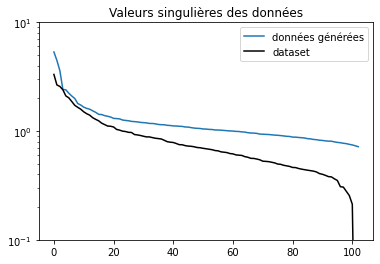

In [25]:
plt.plot(singular_values_gen[-1], label = "données générées")
plt.plot(torch.svd(data[:,:n_sample]/n_sample**0.5)[1].cpu(),color='black', label = "dataset")
plt.semilogy()
plt.legend()
plt.title("Valeurs singulières des données")
plt.ylim(0.1,10);
